# Nuclear saturation

This notebook derives constraints on the nuclear symmetry energy parameters $(S_v,L)$ from chiral EFT calculations in pure neutron matter combined with empirical constraints on the nuclear saturation point.

The notebook is a minimalistic version of `derivatives-bands.ipynb` for this specific purpose.

## Installation

Navigate to the root directory of this repository and follow these instructions to install the codes:

```shell
python3 -m venv venv  # in the root dir of this repository
source venv/bin/activate
python3 -m ipykernel install --name "nuclear-conv"
python3 -m pip install .
python3 -m pip install jupyter
python3 -m pip install corner
python3 -m pip install arviz
python3 -m pip install gsum
python3 -m pip install pymc3
python3 -m pip install statsmodels
python3 -m pip install docrep
python3 -m pip install seaborn
python3 -m pip uninstall gsum
python3 -m pip uninstall gptools
python3 -m pip install git+https://github.com/buqeye/gsum
python3 -m pip install Cython
python3 -m pip install git+https://github.com/markchil/gptools
```

In addition, install:
```shell
python3 -m pip install tqdm
```

## Set up EFT part: neutron matter

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
from nuclear_matter import fermi_momentum, nuclear_density, kf_derivative_wrt_density
from nuclear_matter import compute_pressure, compute_pressure_cov
from nuclear_matter import compute_slope, compute_slope_cov
from nuclear_matter import compute_compressibility, compute_compressibility_cov
from nuclear_matter import compute_speed_of_sound
from nuclear_matter import setup_rc_params
from nuclear_matter import InputData
from nuclear_matter import confidence_ellipse, confidence_ellipse_mean_cov
from nuclear_matter.graphs import add_top_order_legend, compute_filled_handles, plot_empirical_saturation
from nuclear_matter.derivatives import ObservableContainer

Deprecation Warning: 'triangle' has been renamed to 'corner'. This shim should continue to work but you should use 'import corner' in new code. https://github.com/dfm/corner.py


In [2]:
Lambda = 450 #MeV
# Lambda = 500 # MeV

high_density = True
if high_density:
    filename = '../data/all_matter_data_high_density.csv'
else:
    filename = '../data/all_matter_data.csv'
    
data = InputData(filename, Lambda)
density = data.density
Kf_n = data.Kf_n
kf_n = data.kf_n
density_all = np.arange(density[0], density[-1], 0.005)
N_all = len(density_all)
kf_n_all = fermi_momentum(density_all, degeneracy=2)
Kf_n_all = kf_n_all[:, None]
y_n_2_plus_3bf = data.y_n_2_plus_3bf
orders = np.array([0, 2, 3, 4])
train = slice(None, None, 5)
valid = slice(2, None, 5)
breakdown = 600 # MeV
fig_path = 'manuscript_figures'
verbose = True

In [3]:
kf0_n = fermi_momentum(0.16, 2)
kf0_s = fermi_momentum(0.16, 4)

ref_neutron = 16 / kf0_n**2
ref_nuclear = 16 / kf0_s**2

if Lambda == 500:
    std_neutron = 1.00
    ls_neutron = 0.973
elif Lambda == 450:
    std_neutron = 0.8684060649936118
    ls_neutron = 0.7631421388401067

In [4]:
min_uncertainty = 0.02  # Twenty keV
uncertainty_factor = 0.001  # 0.1%
err_y_n = np.abs(y_n_2_plus_3bf[:, -1]) * uncertainty_factor
err_y_n[np.abs(err_y_n) < min_uncertainty] = min_uncertainty

In [5]:
obs_neutron = ObservableContainer(
    density=density,
    kf=kf_n,
    y=y_n_2_plus_3bf,
    orders=orders,
    density_interp=density_all,
    kf_interp=kf_n_all,
    std=std_neutron,
    ls=ls_neutron,
    ref=ref_neutron,
    breakdown=breakdown,
    err_y=err_y_n,
    include_3bf=False,
    derivs=[0, 1, 2],
    verbose=verbose,
)

For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


## Define empirical saturation point

In [6]:
# emp_sat_point_dist = stats.multivariate_normal(
#     mean=[0.17, -16.], 
#     cov=np.diag([0.01**2, 0.1**2])
# )
emp_sat_point_dist = stats.multivariate_t(
    loc=[  0.16083667, -15.9292    ], 
    shape=[[1.07708821e-05, 1.65382275e-04],
       [1.65382275e-04, 2.74842604e-02]],
    df=17
)

num_sats = 101000 #1
np.random.seed(1)
de_sats = emp_sat_point_dist.rvs(num_sats)
d_sats = de_sats[:, 0]
e_sats = de_sats[:, 1]
D_sats = d_sats[:, None]
kf_n_sats = fermi_momentum(d_sats, 2)
Kf_n_sats = kf_n_sats[:, None]
# d_sats

## Constrain the nuclear symmetry energy

Marginalization:
$$
P(S_v,L) = \int dn_0 \, dE_0 \, P(S_v,L \mid n_0, E_0) \, P(n_0, E_0)
$$

In [7]:
# # obtain energy per neutron and its derivative (note: w.r.t. the Fermi momentum, not the density)
# # here are the mean values...
# np.random.seed(1)
# E_and_dE_n_sats, E_and_dE_n_sats_cov = obs_neutron.predict(Kf_n_sats, order=4, derivs=[0, 1])
# E_n_sats = E_and_dE_n_sats[:num_sats]
# dE_n_sats = E_and_dE_n_sats[num_sats:]

# # ...and here the associated covariance matrices
# E_n_sats_cov = E_and_dE_n_sats_cov[:num_sats, :num_sats]
# dE_n_sats_cov = E_and_dE_n_sats_cov[num_sats:, num_sats:]
# E_dE_n_sats_cov = E_and_dE_n_sats_cov[:num_sats, num_sats:]

# # next, we compute the mean and covariance of the slope parameter
# # note that dS2 equals dE at saturation density!
# slope = compute_slope(n=d_sats, kf=kf_n_sats, dS2=dE_n_sats, wrt_kf=True)
# slope_cov = compute_slope_cov(n=d_sats, kf=kf_n_sats, dS2_cov=dE_n_sats_cov, wrt_kf=True)

# # next, let's compute the symmetry energy as the (uncorrelated) difference between 
# # the neutron matter energy per particle and the inferred empirical saturation point
# Sv = E_n_sats - e_sats
# Sv_cov = 1

In [8]:
# import matplotlib.pyplot as plt
# import arviz as az
# import corner
# fig, axes = plt.subplots(2, 2, figsize=(4, 4), constrained_layout=False)
# fig = corner.corner(
#     data=az.from_dict(
#     posterior={"$S_v$": Sv, "$L$": slope}),
#     range=[(28, 36), (5, 100)],
#     labels=[r'$S_v$ [MeV]', r'$L$ [MeV]'], 
#     fig=fig,
#     quantiles=(0.16, 0.5, 0.84), 
#     levels=(1-np.exp(-0.5), 1-np.exp(-0.5*2**2)),
#     show_titles=True, 
#     title_kwargs={"fontsize": 9}
# )

## new

In [9]:
def compute_Esym_L(kf, n, e, S2_dS2, S2_dS2_cov):
    to_Esym_L_mat = np.array([
        [1, 0],
        [0, 3*n*kf_derivative_wrt_density(kf, n)]  # the derivative is w.r.t. to kf, not the density
    ])
    S2_L = to_Esym_L_mat @ S2_dS2 - np.array([e, 0])
    S2_L_cov = to_Esym_L_mat @ S2_dS2_cov @ to_Esym_L_mat.T
    return S2_L, S2_L_cov

In [10]:
from tqdm import tqdm
np.random.seed(1)
num_GP_samples = 50
df = []
for index in tqdm(range(num_sats)):
    E_dE, E_dE_cov = obs_neutron.predict(np.atleast_2d(Kf_n_sats[index]), order=4, derivs=[0, 1])
    E_L_mean, E_L_cov = compute_Esym_L(kf=kf_n_sats[index], n=d_sats[index], e=e_sats[index],
                                       S2_dS2=E_dE, S2_dS2_cov=E_dE_cov)
     # note that the derivative is w.r.t. kf, not the density
    sample = stats.multivariate_normal.rvs(mean=E_L_mean, cov=E_L_cov, size=num_GP_samples)
    df.append(pd.DataFrame(np.atleast_2d(sample), columns=("Sv", "L")))
df = pd.concat(df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101000/101000 [27:04<00:00, 62.18it/s]


Pandas support in corner is deprecated; use ArviZ directly


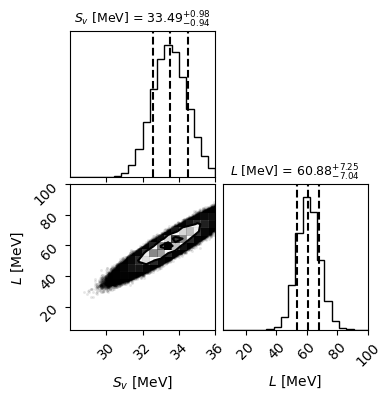

In [11]:
import matplotlib.pyplot as plt
import arviz as az
import corner
fig, axes = plt.subplots(2, 2, figsize=(4, 4), constrained_layout=False)
fig = corner.corner(
    data=df,
    range=[(28, 36), (5, 100)],
    labels=[r'$S_v$ [MeV]', r'$L$ [MeV]'], 
    fig=fig,
    quantiles=(0.16, 0.5, 0.84), 
    levels=(1-np.exp(-0.5), 1-np.exp(-0.5*2**2)),
    show_titles=True, 
    title_kwargs={"fontsize": 9}
)
filename = f"corner_lam_{Lambda}_num_sats_{num_sats}_num_GP_samples_{num_GP_samples}.pdf"
fig.savefig(filename)
df.to_csv(filename.replace(".pdf", ".csv").replace("corner", "samples"))

In [12]:
df.cov().to_numpy()

array([[ 0.93643079,  6.57296244],
       [ 6.57296244, 51.95419266]])

In [13]:
df.mean().to_numpy()

array([33.5111994 , 60.99789384])